In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 72)

import sys
sys.path.append('/home/saikat/Documents/work/sparse-regression/mr-ash-penalized/gradvi-experiments/dsc/functions')
import simulate

from gradvi.inference import LinearRegression
from gradvi.tests import toy_priors

from mrashpen.utils import R_lasso
from mrashpen.inference.mrash_wrapR import MrASHR
from mrashpen.models import mixture_gaussian as mix_gauss

### Generate example data

In [3]:
n = 500
p = 10000
s = 20
pve = 0.6
#rholist = [0.98, 0.98, 0.98]
rholist = [0.99, 0.99, 0.99]
min_block_size = 200

X, y, Xtest, ytest, beta, sigma = simulate.linear_model(n, p, s, pve, ntest = 1000, 
                                                        corr_method = 'blockdiag', rho = rholist, min_block_size = min_block_size,
                                                        seed = 100)

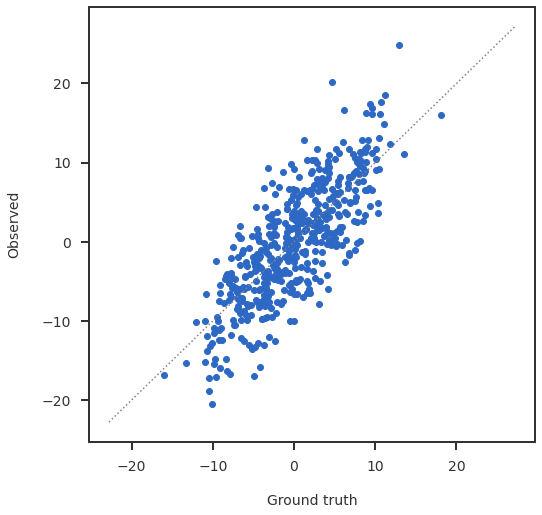

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(np.dot(X, beta), y)
mpl_utils.plot_diag(ax1)
ax1.set_xlabel("Ground truth")
ax1.set_ylabel("Observed")
plt.show()

In [5]:
prior = toy_priors.get_ash_scaled(k = 20, sparsity = None, skbase = 2.0)

In [6]:
prior.w

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

In [7]:
prior.sk

array([0.        , 0.03526492, 0.07177346, 0.10956947, 0.14869835,
       0.18920712, 0.23114441, 0.27456063, 0.31950791, 0.36604026,
       0.41421356, 0.4640857 , 0.51571657, 0.5691682 , 0.62450479,
       0.68179283, 0.74110113, 0.80250093, 0.86606598, 0.93187266])

### Initialize with Lasso

In [8]:
lasso_a0, lasso_b, _ = R_lasso.fit(X, y)
s2init = np.var(y - np.dot(X, lasso_b) - lasso_a0)
winit  = mix_gauss.emfit(lasso_b, prior.sk)
print (winit)

R[write to console]: Loading required package: Matrix



[9.98100000e-01 1.33131640e-05 2.13192494e-05 2.96571047e-05
 3.56290044e-05 4.08380040e-05 4.70889009e-05 5.55797314e-05
 6.56150363e-05 7.62351766e-05 8.73195435e-05 9.94626532e-05
 1.13262500e-04 1.28772869e-04 1.45390648e-04 1.62060667e-04
 1.77593603e-04 1.90944913e-04 2.01382161e-04 2.08535070e-04]


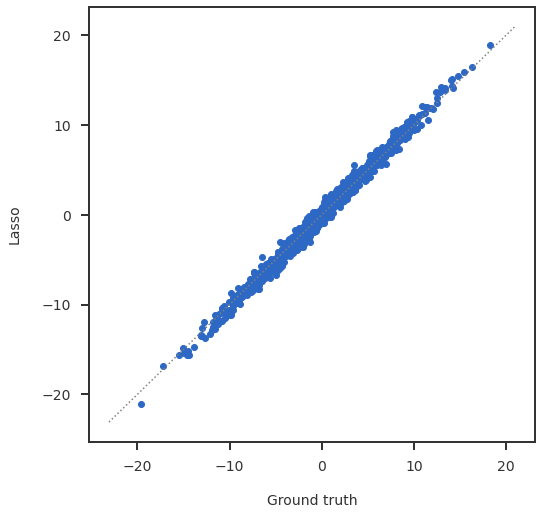

In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(np.dot(Xtest, beta), np.dot(Xtest, lasso_b))
mpl_utils.plot_diag(ax1)
ax1.set_xlabel("Ground truth")
ax1.set_ylabel("Lasso")
plt.show()

### mr.ash

In [10]:
'''
mr.ash.alpha (init)
'''
mrash_init = MrASHR(option = "r2py", debug = False)
mrash_init.fit(X, y, prior.sk, binit = lasso_b, winit = prior.w, s2init = s2init)


'''
mr.ash.alpha
'''
mrash = MrASHR(option = "r2py", debug = False)
mrash.fit(X, y, prior.sk, winit = prior.w)

Mr.ASH terminated at iteration 170.
Mr.ASH terminated at iteration 56.


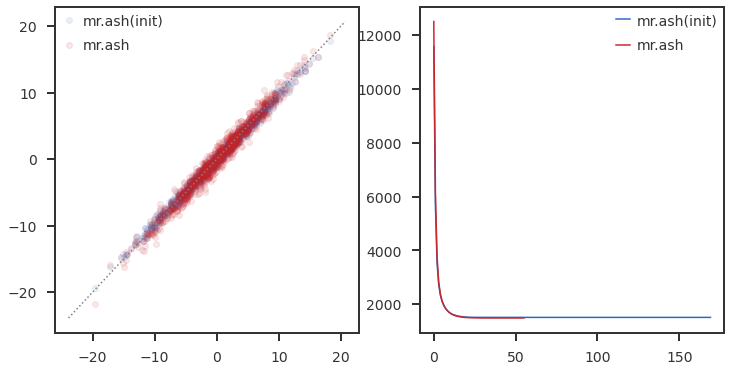

In [11]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(np.dot(Xtest, beta), np.dot(Xtest, mrash_init.coef) + mrash_init.intercept, alpha = 0.1, label = 'mr.ash(init)')
ax1.scatter(np.dot(Xtest, beta), np.dot(Xtest, mrash.coef) + mrash.intercept, alpha = 0.1, label = 'mr.ash')
mpl_utils.plot_diag(ax1)
ax1.legend()


ax2.plot(range(mrash_init.niter), mrash_init.obj_path, label = 'mr.ash(init)')
ax2.plot(range(mrash.niter), mrash.obj_path, label = 'mr.ash')
ax2.legend()

plt.show()

### GradVI

In [12]:
gv = LinearRegression(obj = 'reparametrize')
gv.fit(X, y, prior)

In [13]:
gv.niter

20

In [14]:
gv_init = LinearRegression(obj = 'reparametrize')
gv_init.fit(X, y, prior, b_init = lasso_b, s2_init = s2init)

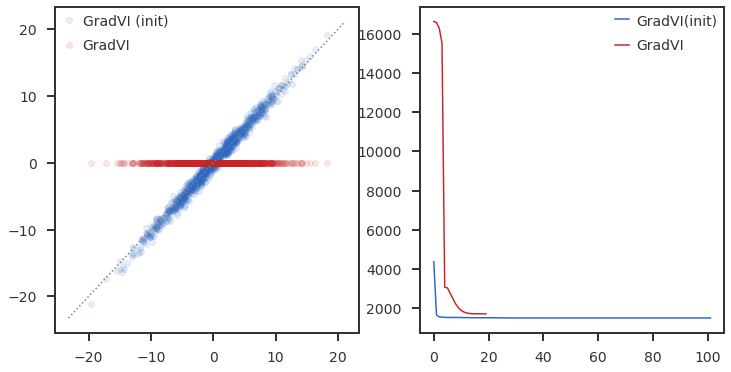

In [15]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(np.dot(Xtest, beta), np.dot(Xtest, gv_init.coef) + gv_init.intercept, alpha = 0.1, label = 'GradVI (init)')
ax1.scatter(np.dot(Xtest, beta), np.dot(Xtest, gv.coef) + gv.intercept, alpha = 0.1, label = 'GradVI')
mpl_utils.plot_diag(ax1)
ax1.legend()


ax2.plot(range(gv_init.niter), gv_init.elbo_path, label = 'GradVI(init)')
ax2.plot(range(gv.niter), gv.elbo_path, label = 'GradVI')
ax2.legend()

plt.show()

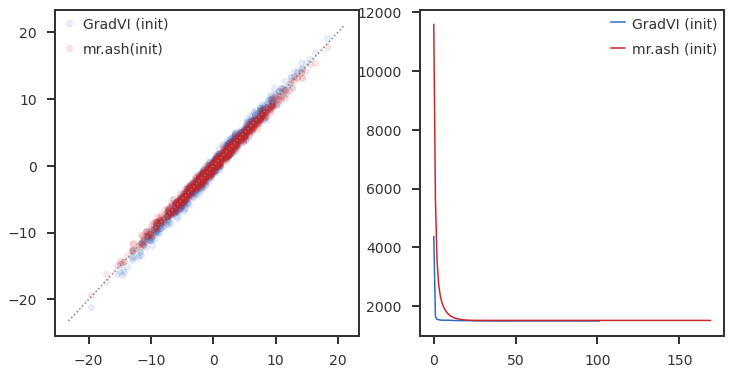

In [16]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(np.dot(Xtest, beta), np.dot(Xtest, gv_init.coef) + gv_init.intercept, alpha = 0.1, label = 'GradVI (init)')
ax1.scatter(np.dot(Xtest, beta), np.dot(Xtest, mrash_init.coef) + mrash_init.intercept, alpha = 0.1, label = 'mr.ash(init)')
mpl_utils.plot_diag(ax1)
ax1.legend()


ax2.plot(range(gv_init.niter), gv_init.elbo_path, label = 'GradVI (init)')
ax2.plot(range(mrash_init.niter), mrash_init.obj_path, label = 'mr.ash (init)')
ax2.legend()

plt.show()

In [17]:
- gv_init.elbo_path[-1] + mrash_init.elbo_path[-1]

19.369032345381356

In [18]:
mrash_init.elbo_path[-1]

1513.008134345426

In [19]:
gv_init.elbo_path[-1]

1493.6391020000447